# 0. Import

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
from datetime import datetime, time

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Time Series
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from prophet.plot import add_changepoints_to_plot

# Pytorch
import torch
import torch.nn as nn

# Visualization Libraries
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Load Data

In [2]:
df = pd.read_csv('data/IPG2211A2N.csv')

# 2. Examine the data

In [3]:
df.head()

observation_date  IPG2211A2N
0       1939-01-01      3.3336
1       1939-02-01      3.3591
2       1939-03-01      3.4354
3       1939-04-01      3.4608
4       1939-05-01      3.4608

In [4]:
# Rename columns
df = df.rename(columns = {'observation_date': 'date', 'IPG2211A2N': 'production'})

In [5]:
def summary(df):
    print(f'data shape: {df.shape}')  
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

In [6]:
summary(df).style.background_gradient(cmap='Blues')

data shape: (972, 2)


In [7]:
min_date = df['date'].min()
max_date = df['date'].max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 1939-01-01
Maximum Date: 2019-12-01


In [8]:
df.duplicated().sum()

0

In [9]:
duplicate_dates = df[df.duplicated('date', keep=False)]

# display duplicate dates
print("Duplicate Dates:")
print(duplicate_dates[['date']])

Duplicate Dates:
Empty DataFrame
Columns: [date]
Index: []


In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='MS')  # 'MS' for start of the month

if df['date'].isin(date_range).all():
    print("The 'date' column is at a consistent monthly frequency and there are no missing dates.")
else:
    print("There are missing or extra dates.")

The 'date' column is at a consistent monthly frequency and there are no missing dates.


In [12]:
df = df.set_index('date')

df.tail()

production
date                  
2019-08-01    112.3547
2019-09-01    103.1333
2019-10-01     93.8206
2019-11-01     99.9782
2019-12-01    109.9263

# 3. Data Exploration

In this phase, we aim to understand the characteristics of our time series data, focusing on its univariate nature, seasonality, and stationarity, which are key factors in selecting the appropriate forecasting models.

### Nature of the Data

The data we are working with is **univariate**, meaning it consists of a single time-dependent variable. This simplifies the modeling process as we do not have to account for multiple input variables, but we must still consider seasonality and trend components within the series.

### Time Series Models for Forecasting

Several models can be employed for time series forecasting. In this project, we will explore both **traditional statistical models** and **machine learning models**:

- **ARIMA (AutoRegressive Integrated Moving Average)**: 
  ARIMA is a widely-used method for univariate time series forecasting. It requires the data to be **stationary**, meaning that the statistical properties (mean, variance, etc.) do not change over time. ARIMA is ideal when the data shows patterns like trends but no significant seasonal behavior.
  
- **SARIMA (Seasonal ARIMA)**: 
  SARIMA is an extension of ARIMA that incorporates seasonal components, making it useful for time series with clear seasonality. It can handle both trends and seasonality without needing to remove the seasonal effects beforehand. However, stationarity is still required for the residuals.

- **SARIMAX (Seasonal ARIMA with eXogenous variables)**: 
  This model is similar to SARIMA but can also include external variables (e.g., weather, holidays) that might influence the time series. Like SARIMA, it can handle seasonality but requires the data to be stationary.

### Machine Learning Models

In addition to the traditional models, we will explore **machine learning techniques** such as **LSTM (Long Short-Term Memory)** networks, which are well-suited for sequential data and do not require stationarity. These models are capable of learning complex patterns, including both trends and seasonality, without needing explicit feature engineering for stationarity or seasonality.

### Stationarity and Seasonality

- **Stationarity**: Some models (like ARIMA, SARIMA, and SARIMAX) assume that the data is stationary. If the data exhibits trends or changing variance over time, we must apply techniques such as differencing or log transformation to achieve stationarity.
  
- **Seasonality**: Seasonal components (e.g., monthly or yearly cycles) are another critical factor in time series modeling. ARIMA cannot handle seasonality directly, so it requires pre-processing, like seasonal differencing. SARIMA and SARIMAX can model seasonality by including seasonal terms. Machine learning models like LSTM can automatically learn seasonal patterns from the data without needing any prior adjustments.



In [13]:
amount_data = df['production']

Q1 = np.percentile(amount_data, 25)
Q3 = np.percentile(amount_data, 75)

IQR = Q3 - Q1

upper_bound = Q3 + 1.2 * IQR

outliers = amount_data > upper_bound

print("Outliers:", np.sum(outliers))

Outliers: 0


# 3.1 Visualizing the Time Series Data

In [14]:
fig = px.line(df, x=df.index, y=df.production)

fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Values"
)

fig.show()

In [15]:
df_month = df.copy()

In [16]:
df_month['month'] = df_month.index.month
monthly_avg_production = df_month.groupby('month')['production'].mean()


fig = px.bar(
    monthly_avg_production.reset_index(),
    x='month',
    y='production',
    title='Average Monthly Production',
    labels={'month': 'Month', 'production': 'Average Production'}
)

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=[
            'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
        ]
    ),
    height=400,  
    width=600
)

fig.show()

By looking at the above plot we can see, there is an upward trend over the period of time.

There is also increase in the variance over time.(Length of the spikes)

In [17]:
desc_stats = df.describe()
desc_stats.T

count       mean        std     min      25%      50%       75%  \
production  972.0  54.003226  34.992848  3.3336  19.2891  54.2013  86.54305   

                 max  
production  126.3772

The minimum production recorded is 3.33 to a maximum of 126.38 indicating a significant range of variability. The mean production is 54.00, which is relatively close to the median (50th percentile) of 54.20, indicating a somewhat symmetrical distribution. 

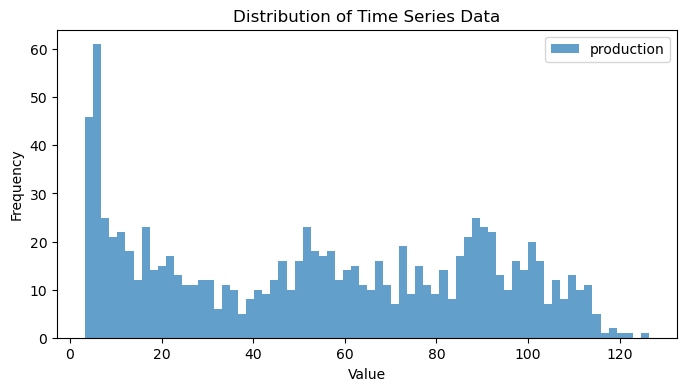

In [18]:
df.plot(kind='hist', bins=70, figsize=(8, 4), alpha=0.7)
plt.title('Distribution of Time Series Data')
plt.xlabel('Value')
plt.show()



In [19]:
def plot_rolling_stats(df, window=12):

    rolling_mean = df.rolling(window=window).mean()
    rolling_std = df.rolling(window=window).std()
    
    # Plotting the data
    plt.figure(figsize=(12, 6))
    plt.plot(df, label='Original Data')
    plt.plot(rolling_mean, label='Rolling Mean', color='red', linewidth=2)
    plt.plot(rolling_std, label='Rolling Std', color='green', linestyle='--', linewidth=2)
    
    plt.title('Original Data with Rolling Mean and Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

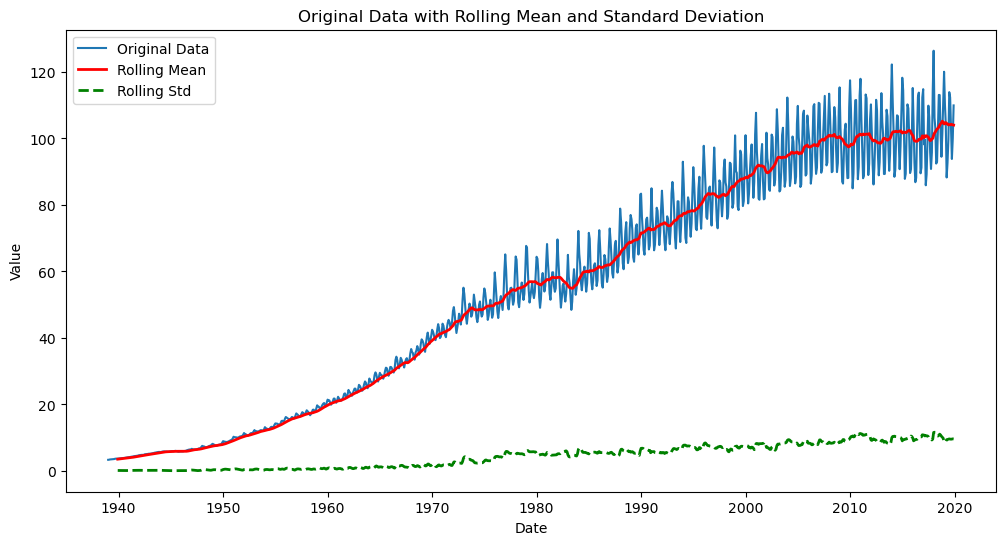

In [20]:
plot_rolling_stats(df, window=12)

We observe that standard deviation is some what constant, but mean is not constant.

The choice of 12 as the window for rolling statistics is typically based on monthly time series data, where there are 12 months in a year. This makes the rolling mean and standard deviation calculated over 12 months appropriate for capturing seasonal trends and fluctuations on an annual basis.

# 3.2 Decompose the data

The building blocks of a time series analysis are seasonality, trend, and cycle. These intuitive components capture the historical patterns in the series. 

- **Seasonality** reflects periodic fluctuations, like higher production in colder months.
- **Trend** represents the overall direction, such as increasing or decreasing production over time.
- **Cycle** captures non-seasonal patterns, often combined with trend, and is smoothed out using moving averages.
- The remaining irregular behavior is called **residuals** or **error**.

For modeling, we can decompose the series using either:

- **Additive Model**: Used when components are not proportional to the series level (simply added together).
- **Multiplicative Model**: Used when seasonality and trend change with the series level, requiring a proportional interaction.

ARIMA models can handle both seasonal and non-seasonal data. **Seasonal ARIMA** requires more complex specifications, while de-seasonalizing the data allows for a standard ARIMA model.

An **additive model** is suitable when the trend and seasonality are constant, such as adding a fixed amount each year. A **multiplicative model** is better when the trend or seasonality changes at a non-linear rate, such as exponential growth or decline.

Based on the previous chart, the trend appears to be increasing slightly at a faster rate than linear. Although it's hard to determine definitively from a single plot, we can experiment with both additive and multiplicative models to assess the best fit.

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

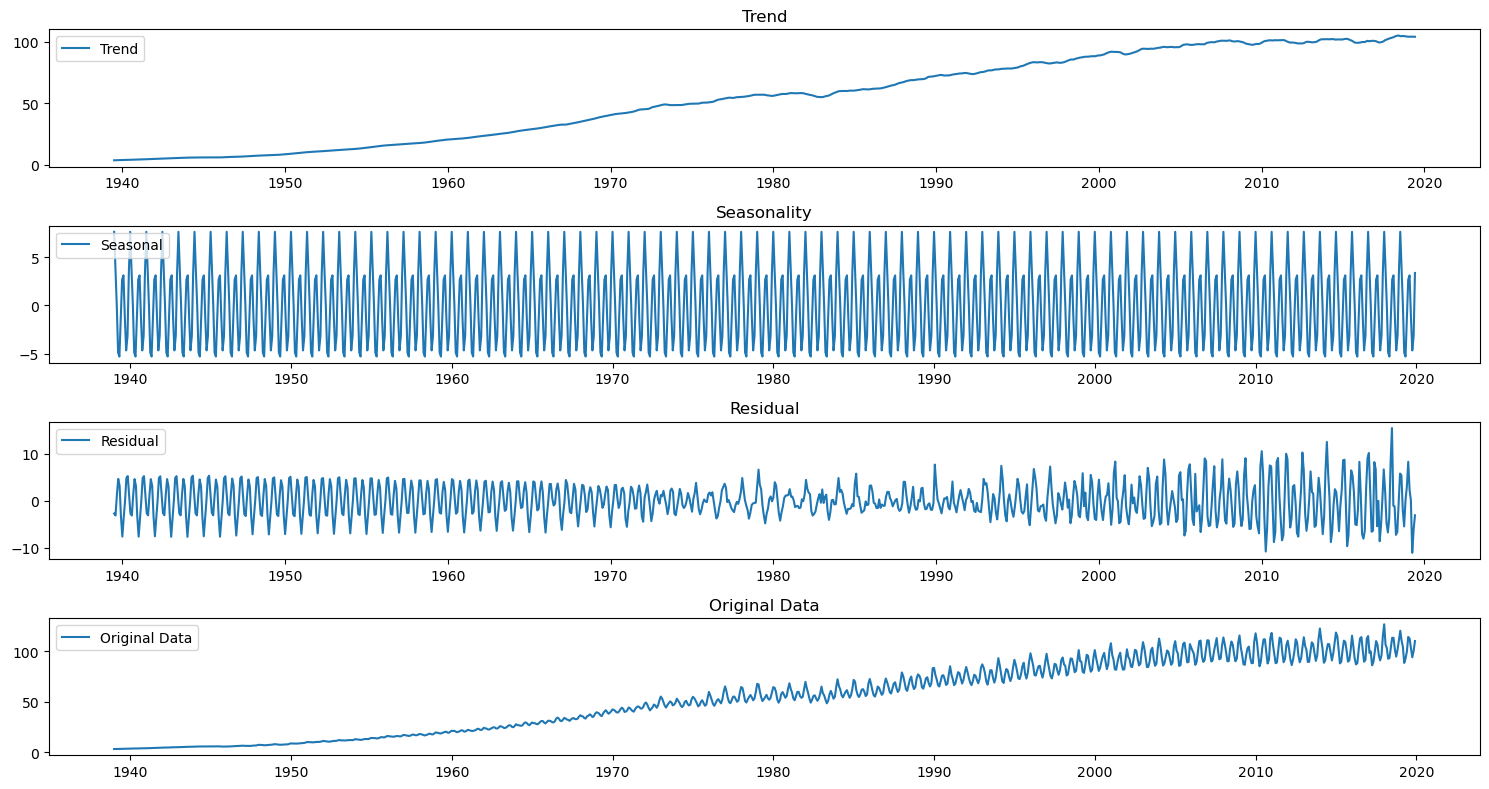

In [22]:
decomposition = seasonal_decompose(df, model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 8))

plt.subplot(4, 1, 1)
plt.plot(df.index, trend, label='Trend' )
plt.legend(loc='upper left')
plt.title('Trend')

plt.subplot(4, 1, 2)
plt.plot(df.index, seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(df.index, residual, label='Residual', linestyle='-', marker=None)
plt.legend(loc='upper left')
plt.title('Residual')

plt.subplot(4, 1, 4)
plt.plot(df.index, df, label='Original Data')
plt.legend(loc='upper left')
plt.title('Original Data')

plt.tight_layout()
plt.show()

In [23]:
seasonal_df = seasonal.reset_index()

seasonal_df['month'] = seasonal_df['date'].dt.month
seasonal_df['year'] = seasonal_df['date'].dt.year

monthly_avg = seasonal_df.groupby('month')['seasonal'].mean()

monthly_ranking = monthly_avg.sort_values(ascending=False)

print("Ranked months based on average seasonal value:")
print(monthly_ranking)

Ranked months based on average seasonal value:
month
1     7.617624
2     3.561548
12    3.361913
8     3.113232
7     2.677211
3     0.123202
9    -1.239762
6    -1.261442
11   -3.151673
10   -4.647439
4    -4.872562
5    -5.281852
Name: seasonal, dtype: float64


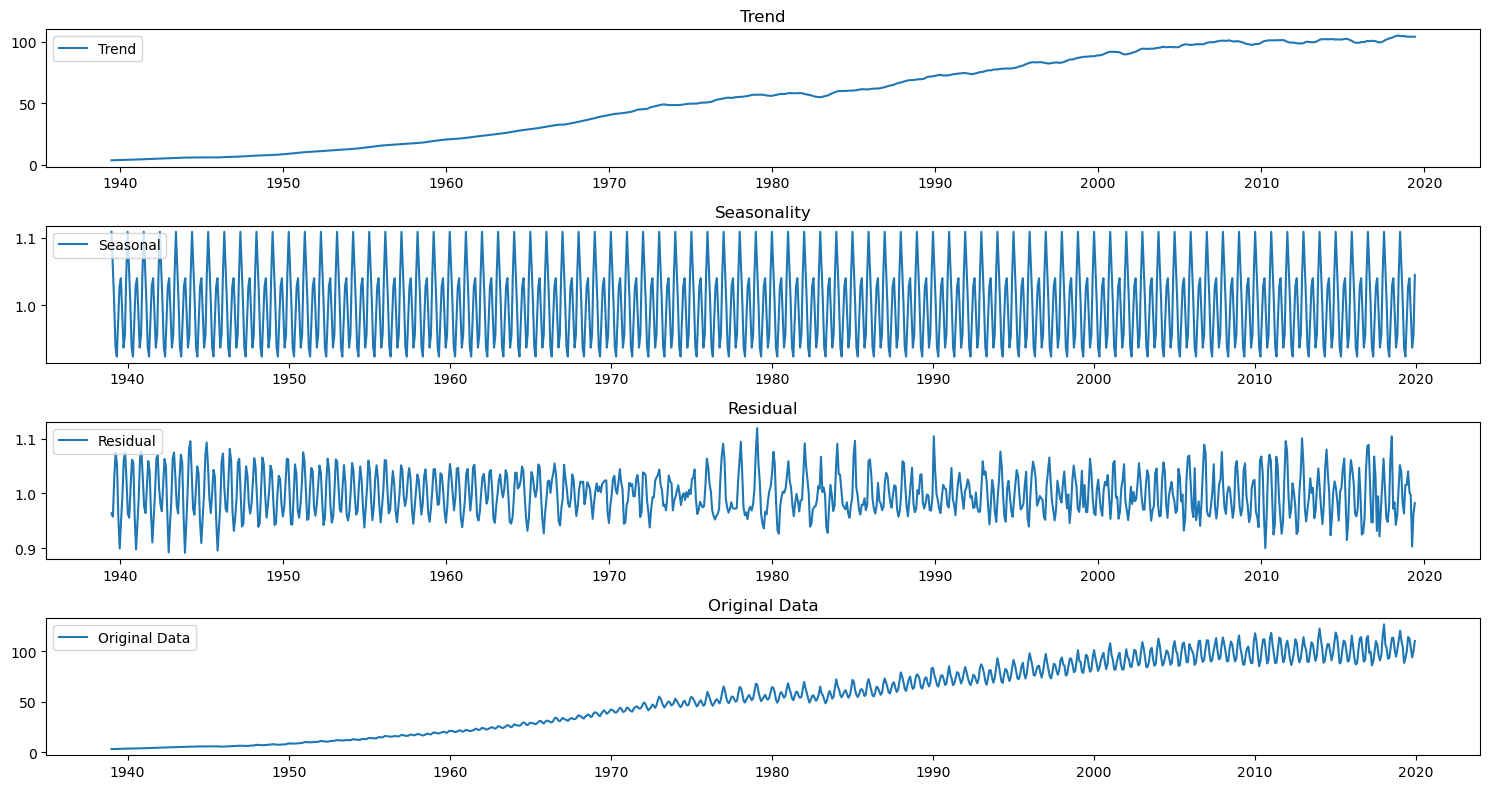

In [24]:

decomposition = seasonal_decompose(df, model='multiplicative', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 8))

plt.subplot(4, 1, 1)
plt.plot(df.index, trend, label='Trend' )
plt.legend(loc='upper left')
plt.title('Trend')

plt.subplot(4, 1, 2)
plt.plot(df.index, seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(df.index, residual, label='Residual', linestyle='-', marker=None)
plt.legend(loc='upper left')
plt.title('Residual')

plt.subplot(4, 1, 4)
plt.plot(df.index, df, label='Original Data')
plt.legend(loc='upper left')
plt.title('Original Data')

plt.tight_layout()
plt.show()

The time series data has been decomposed into its components to better understand its structure. The decomposition consists of three key components:

1. **Trend**: The trend component indicates that the series is experiencing an overall upward movement over time.
2. **Seasonality**: The dataset exhibits monthly seasonality, meaning the time series follows a recurring pattern every year, with December, January, February showing the highest seasonal influence, suggesting consistently elevated production levels wich is logical because in winther the gas and electirical consumption gets higher, while April and May exhibits the lowest seasonal values, indicating reduced production during this period.
3. **Residual**: The residuals show random fluctuations around the trend and seasonality, capturing the irregularities or noise in the data.


# 3.3 Stationarity

As we talked about before we will be using the models ARIMA and SARIMA so an important phase is to test for stationarity. A time series is stationary if its statistical properties, such as mean and variance, do not change over time.

By ensuring stationarity and selecting the right model (ARIMA/SARIMA), we can improve the accuracy and reliability of our forecasts.

The **Augmented Dickey-Fuller (ADF) Test** checks if a time series is **stationary** or if it has a **unit root**, which indicates non-stationarity.

- **Null Hypothesis (H0):** The time series has a unit root, meaning it's non-stationary.
- **Alternate Hypothesis (H1):** The time series does not have a unit root, meaning it's stationary.

#### Interpretation:
- **p-value > 0.05**: Fail to reject H0, meaning the series is **non-stationary**.
- **p-value <= 0.05**: Reject H0, meaning the series is **stationary**.





In [25]:

result = adfuller(df['production'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.3399194400664068
p-value: 0.9196571716060372
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


The **Dickey-Fuller Test** yields a p-value of 0.9, which means we fail to reject the null hypothesis that the time series is non-stationary. This indicates that the time series likely contains a **unit root**, which points to non-stationarity, possibly due to trends or seasonality present in the data.

### Addressing Non-Stationarity:
It is common to encounter non-stationary time series data, typically caused by the following factors:

1. **Trend**: The series shows an overall shift in its mean over time.
2. **Seasonality**: Fluctuations in the data repeat at regular intervals (e.g., monthly, yearly).

Several techniques can be applied to transform a non-stationary time series into a stationary one:

#### Methods for Handling Non-Stationarity:

1. **Transformation**: Adjusting the data to stabilize variance or remove trends. Common transformations include:
   - **Log Transformation**
   - **Square Root Transformation**

2. **Smoothing**: Applying methods to reduce noise and identify long-term trends, such as Rolling Averages.

3. **Differencing**: Removing trends by subtracting values at one time step from those at the previous time step (e.g., **first-order differencing**).

4. **Polynomial Fitting**: Using polynomial regression to model the trend, effectively removing it and leaving a stationary residual series.

5. **Decomposition**: Breaking the series into its constituent components (trend, seasonality, and residual) allows us to model them separately and address non-stationarity.

By applying these techniques, we can transform the time series into a stationary form.


# Data Transformation and Stationarity Handling

In [26]:
df_compare_stationarity = df.copy()

In [27]:
def plot_transformed_data(df, production_transform):

    f, ax = plt.subplots(1,1)
    ax.plot(df['production'])
    ax.plot(df[production_transform], color = 'red')
    
    ax.set_title('%s and %s time-series graph' %('production', production_transform))
    
    ax.tick_params(axis = 'x', rotation = 45)
    
    ax.legend(['production', production_transform])
    
    plt.show()
    plt.close()
    
    return

In [28]:
df_compare_stationarity['log_transformed'] = np.log(df_compare_stationarity['production'])

In [29]:
df_compare_stationarity['sqrt_transformed'] = np.sqrt(df_compare_stationarity['production'])

In [30]:
df_compare_stationarity['diff_transformed'] = df_compare_stationarity['production'].diff()
# this is the same as df['diff2_transformed'] = df['production'] - df['production'].shift(1) as it computes the difference between each element and its previous element

In [31]:
df_compare_stationarity['diff2_transformed'] = df_compare_stationarity['production'] - df_compare_stationarity['production'].shift(2)

In [32]:
df_compare_stationarity['log_diff'] = df_compare_stationarity['log_transformed'].diff()

In [33]:
df_compare_stationarity['rolling_avg'] = df_compare_stationarity['production'].rolling(window=3).mean()


In [34]:
df_compare_stationarity['diff_transformed'] = df_compare_stationarity['diff_transformed'].fillna(method='bfill')
df_compare_stationarity['diff2_transformed'] = df_compare_stationarity['diff2_transformed'].fillna(method='bfill')
df_compare_stationarity['rolling_avg'] = df_compare_stationarity['rolling_avg'].fillna(method='bfill')
df_compare_stationarity['log_diff'] = df_compare_stationarity['log_diff'].fillna(method='bfill')


In [35]:
df_compare_stationarity.head()

production  log_transformed  sqrt_transformed  diff_transformed  \
date                                                                          
1939-01-01      3.3336         1.204053          1.825815            0.0255   
1939-02-01      3.3591         1.211673          1.832785            0.0255   
1939-03-01      3.4354         1.234133          1.853483            0.0763   
1939-04-01      3.4608         1.241500          1.860323            0.0254   
1939-05-01      3.4608         1.241500          1.860323            0.0000   

            diff2_transformed  log_diff  rolling_avg  
date                                                  
1939-01-01             0.1018  0.007620     3.376033  
1939-02-01             0.1018  0.007620     3.376033  
1939-03-01             0.1018  0.022460     3.376033  
1939-04-01             0.1017  0.007366     3.418433  
1939-05-01             0.0254  0.000000     3.452333

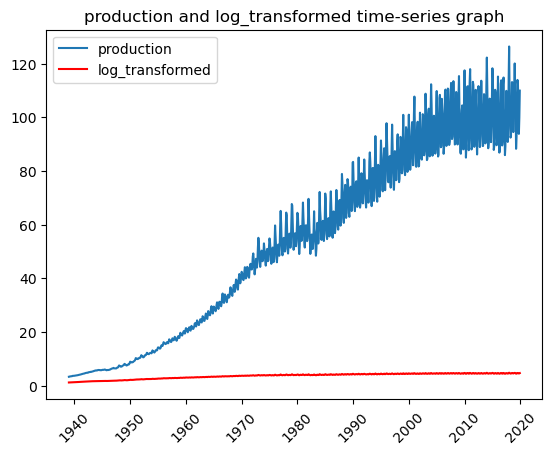

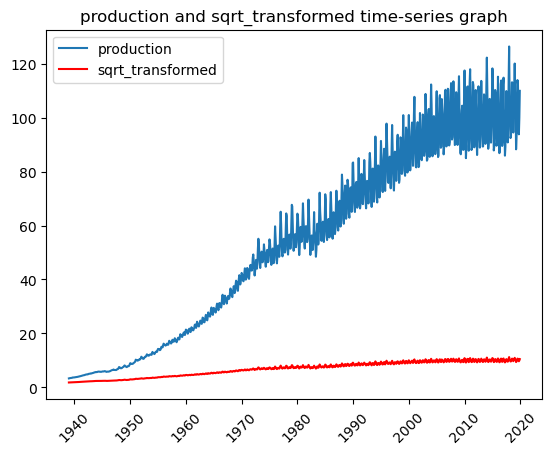

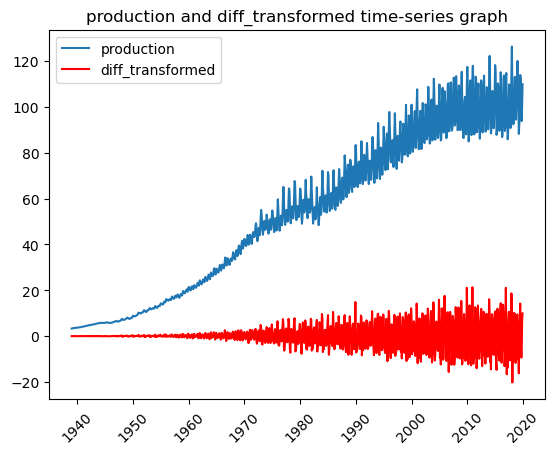

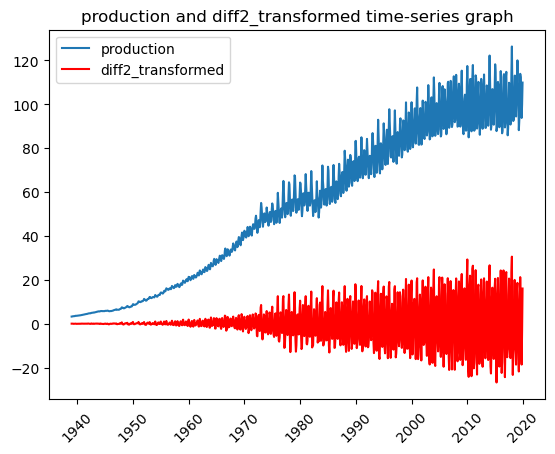

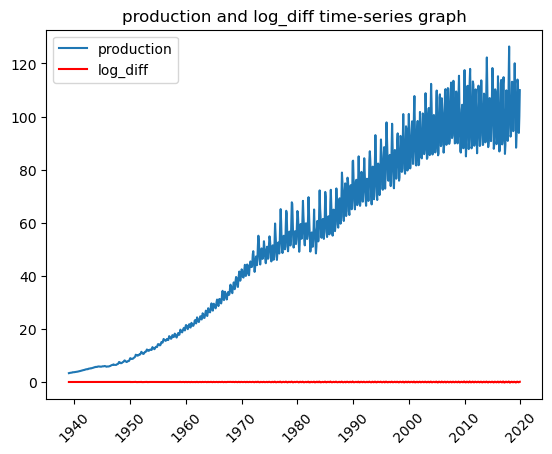

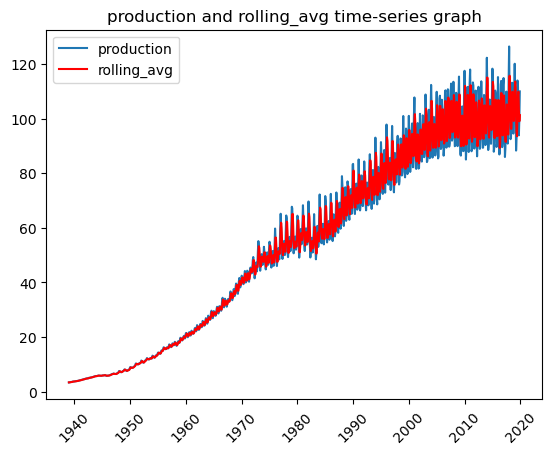

In [36]:
plot_transformed_data(df = df_compare_stationarity,
                     production_transform = 'log_transformed')

plot_transformed_data(df = df_compare_stationarity,
                     production_transform = 'sqrt_transformed')

plot_transformed_data(df = df_compare_stationarity,
                     production_transform = 'diff_transformed')

plot_transformed_data(df = df_compare_stationarity,
                     production_transform = 'diff2_transformed')

plot_transformed_data(df = df_compare_stationarity,
                     production_transform = 'log_diff')

plot_transformed_data(df = df_compare_stationarity,
                     production_transform = 'rolling_avg')

In [37]:
def evaluate_stationarity(df, production):
    transformations = ['log_transformed', 'sqrt_transformed', 'diff_transformed', 'diff2_transformed', 'log_diff', 'rolling_avg']
    results = {}

    for transformation in transformations:
        if transformation in df.columns:  # Ensure the column exists
            adf_result = adfuller(df[transformation].dropna())
            test_statistic = adf_result[0]
            p_value = adf_result[1]
            critical_values = adf_result[4]  # This contains the critical values
            results[transformation] = {
                'p_value': p_value,
                'test_statistic': test_statistic,
                'critical_values': critical_values
            }
    
    return results

def select_best_transformation(df, production):
    results = evaluate_stationarity(df, production)
    
    print("ADF results for different transformations:")
    for transformation, result in results.items():
        print(f"\nTransformation: {transformation}")
        print(f"ADF test statistic: {result['test_statistic']}")
        print(f"ADF p-value: {result['p_value']}")
        print("Critical values:")
        for key, value in result['critical_values'].items():
            print(f"  {key}: {value}")
    
    best_transformation = min(results, key=lambda x: results[x]['p_value'])
    
    print(f"\nBest transformation based on ADF p-value: {best_transformation}")
    return best_transformation

best_transformation = select_best_transformation(df_compare_stationarity, 'production')

ADF results for different transformations:

Transformation: log_transformed
ADF test statistic: -6.286865300085248
ADF p-value: 3.679855408397016e-08
Critical values:
  1%: -3.43725945868569
  5%: -2.8645903751292536
  10%: -2.5683941938438886

Transformation: sqrt_transformed
ADF test statistic: -3.2952749095332283
ADF p-value: 0.015091011868278938
Critical values:
  1%: -3.43725945868569
  5%: -2.8645903751292536
  10%: -2.5683941938438886

Transformation: diff_transformed
ADF test statistic: -10.145535007064678
ADF p-value: 8.205020169974459e-18
Critical values:
  1%: -3.43725945868569
  5%: -2.8645903751292536
  10%: -2.5683941938438886

Transformation: diff2_transformed
ADF test statistic: -8.578749912947679
ADF p-value: 7.832315645287567e-14
Critical values:
  1%: -3.43725945868569
  5%: -2.8645903751292536
  10%: -2.5683941938438886

Transformation: log_diff
ADF test statistic: -5.451418137572275
ADF p-value: 2.639197834956427e-06
Critical values:
  1%: -3.43725945868569
  5%: -

Based on the results applying differencing made the data more stationary over time.

For now we will choose to work with it.

In [38]:
df_diff = df.copy()

In [39]:
df_diff = df_diff.diff()
df_diff = df_diff.dropna()

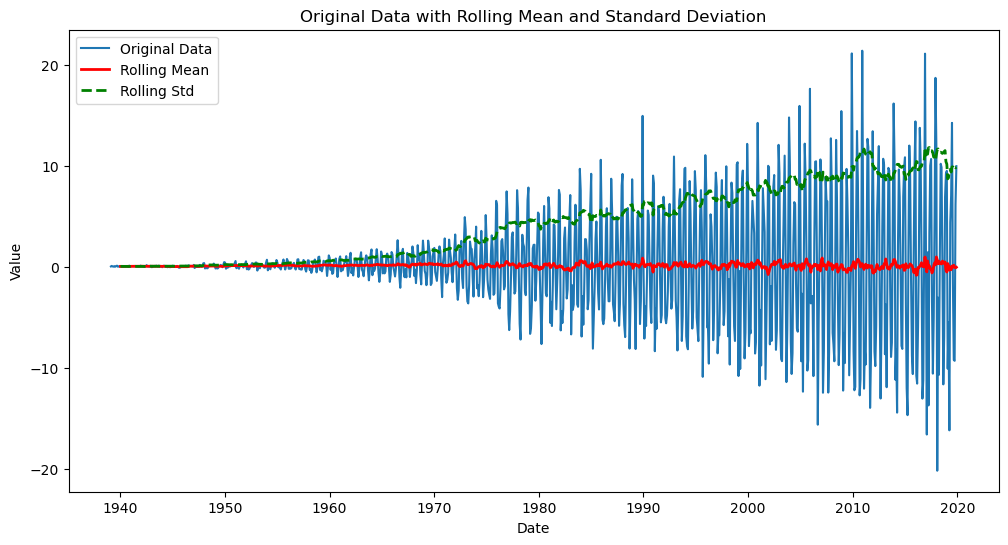

In [40]:
plot_rolling_stats(df_diff, window=12)

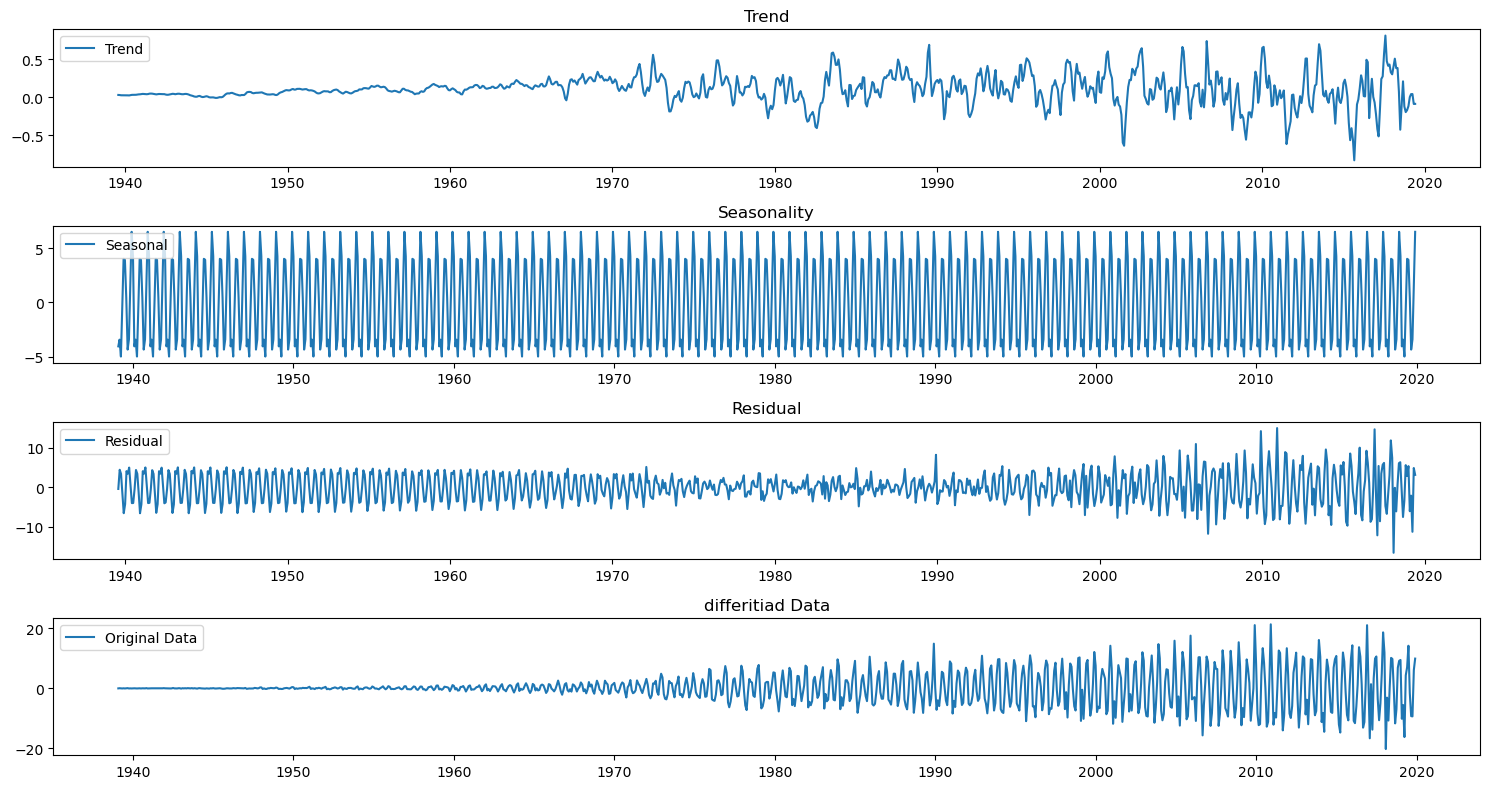

In [41]:
decomposition = seasonal_decompose(df_diff, model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 8))

plt.subplot(4, 1, 1)
plt.plot(df_diff.index, trend, label='Trend' )
plt.legend(loc='upper left')
plt.title('Trend')

plt.subplot(4, 1, 2)
plt.plot(df_diff.index, seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(df_diff.index, residual, label='Residual', linestyle='-', marker=None)
plt.legend(loc='upper left')
plt.title('Residual')

plt.subplot(4, 1, 4)
plt.plot(df_diff.index, df_diff, label='Original Data')
plt.legend(loc='upper left')
plt.title('differitiad Data')

plt.tight_layout()
plt.show()

with differnciating the data we succefully removed the trend and made the data stationary

# 3.4 Handling Seasonality

In order to work properly later on on model building we need ti frist adress seasonality and we will explain it's imporatnce later on.

In [42]:
df_s_d =df_diff.copy()

In [43]:
df_s_d

production
date                  
1939-02-01      0.0255
1939-03-01      0.0763
1939-04-01      0.0254
1939-05-01      0.0000
1939-06-01      0.0509
...                ...
2019-08-01     -1.5639
2019-09-01     -9.2214
2019-10-01     -9.3127
2019-11-01      6.1576
2019-12-01      9.9481

[971 rows x 1 columns]

In [44]:
df_s_d['production'] = df_s_d['production'] - df_s_d['production'].shift(12)
df_s_d = df_s_d.dropna()


In [45]:
# df_s_d.to_csv('data_non_seasonal.csv')


# Model Building

Before starting with the modeling phase an imporant notion when working on forcasting timeseries is: 
### In-Sample vs Out-of-Sample Predictions

#### In-Sample Predictions
These predictions cover the periods already included in the training data. They help assess how well the model fits historical data, using metrics like Mean Squared Error (MSE) or Root Mean Squared Error (RMSE). The predict method is used to generate these values.

#### Out-of-Sample Predictions
These predictions extend beyond the training data, focusing on future periods. They are used for forecasting and trend projection for unseen data. The forecast method is typically applied to obtain these predictions.

---

##### Key Difference:
- **In-Sample**: Validates the model on known data.
- **Out-of-Sample**: Projects the model onto new, unseen time periods.

### SARIMA 
In general, for seasonal time series data, SARIMA are often the better choice than ARIMA because they can directly model the seasonal component. In our case the data have seasonal caracteristics so we will work wit SARIMA a


#### SARIMA vs. SARIMAX

##### SARIMA
SARIMA (Seasonal ARIMA) models time series data with seasonal patterns by combining:
- **AR**: AutoRegressive component (uses past values)
- **I**: Integrated component (makes the series stationary)
- **MA**: Moving Average component (uses past forecast errors)
- **S**: Accounts for seasonal patterns

##### SARIMAX
SARIMAX extends SARIMA by including **exogenous variables (X)**, external factors that might affect the time series (e.g., economic indicators, weather).

##### Key Differences
- **SARIMA**: Uses only past values and seasonal components.
- **SARIMAX**: Includes both seasonal components and external variables.

---

#### ACF and PACF Tests

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are essential tools for identifying the appropriate orders of AR (AutoRegressive) and MA (Moving Average) terms in time series models like ARIMA and SARIMA.

- **ACF** (AutoCorrelation Function) identifies the **MA order** by showing how past residuals affect the current value.
- **PACF** (Partial AutoCorrelation Function) helps determine the **AR order** by showing direct correlations with lags, removing the influence of earlier lags.

##### How to interpret ACF and PACF plots?

- **p** : Count the number of significant lags in the PACF plot. This indicates the order of the AR component (p). A gradual decay in the PACF means that higher p might be required.
- **d** : Number of times differencing is carried out to make the time series stationary.
- **q** : If the ACF decays slowly, the model might need a higher q. If the ACF cuts off after a specific lag (abrupt drop), this indicates the q parameter.
 
 For the seasonal components
 
- **P**  we should look for significant spikes at seasonal lags.
- **D**  The seasonal differencing order is the number of times seasonal differencing is applied to remove seasonality.
- **Q**  the ACF shows spikes at multiples of the seasonal period. For instance, if you have monthly data with yearly seasonality, you might see significant spikes at lags 12, 24, etc.
- **m**  The number of periods in a season represents the seasonal cycle length (e.g., 12 for monthly data with annual seasonality).

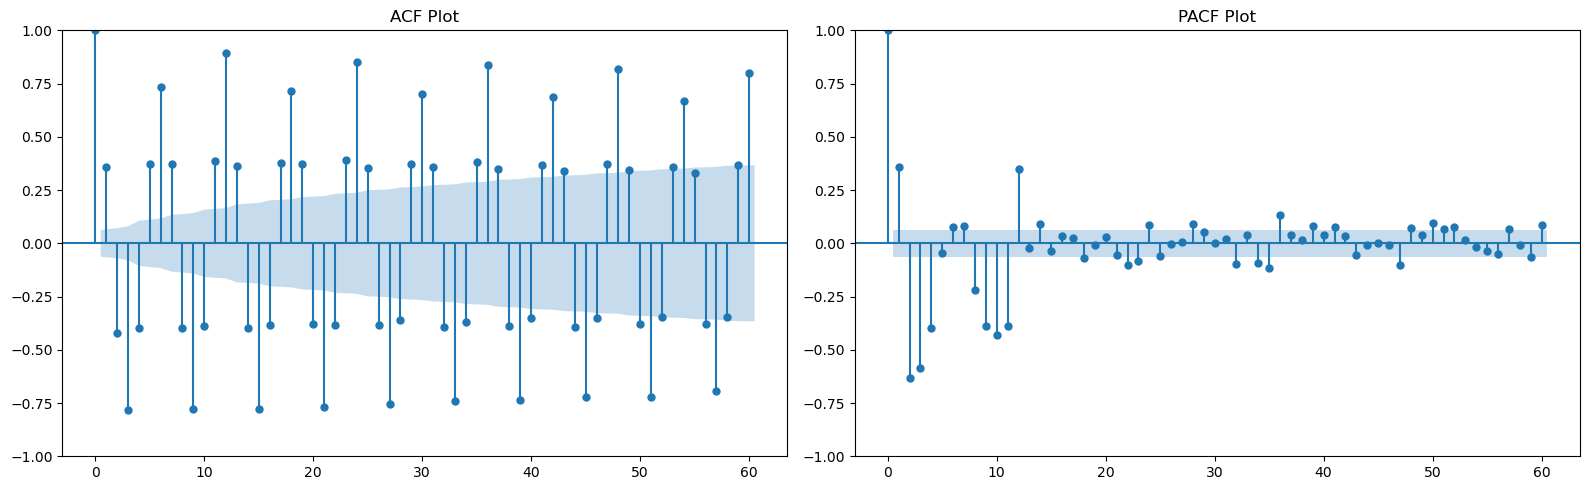

In [46]:

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df_diff, lags=60, ax=axes[0])
axes[0].set_title('ACF Plot')

plot_pacf(df_diff, lags=60, ax=axes[1])
axes[1].set_title('PACF Plot')

plt.tight_layout()
plt.show()

we might need to select higher values of p (AR) and q (MA) values as ACF has slow decay and this might indicate that your series still exhibits some long-range dependencies

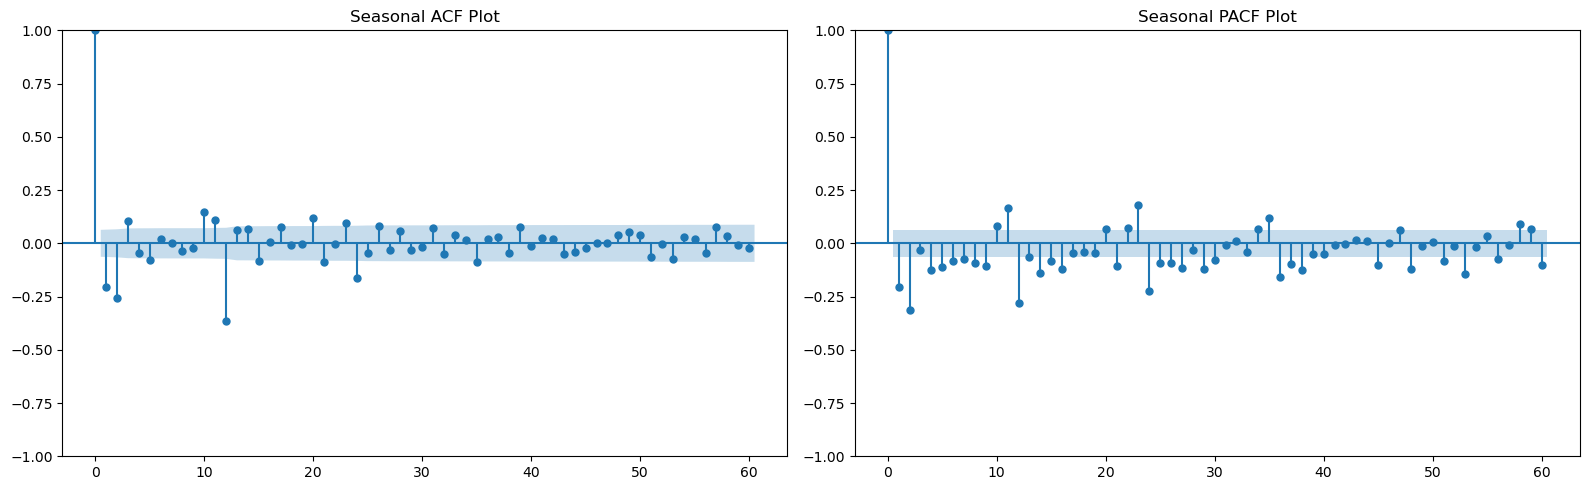

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df_s_d, lags=60, ax=axes[0])
axes[0].set_title('Seasonal ACF Plot')

plot_pacf(df_s_d, lags=60, ax=axes[1])
axes[1].set_title('Seasonal PACF Plot')

plt.tight_layout()
plt.show()

ACF cuts off sharply at a certain seasonal lag of 12

### Explanation of SARIMA Parameters

In this analysis, we determined the following SARIMA parameters:

- **p = 4**, **d = 1**, **q = 3**
- **P = 4**, **D = 1**, **Q = 2**, **m = 12**

#### 1. **Non-Seasonal Parameters (p, d, q)**

- **d = 1 (Differencing order)**: 
  The data was stationary after applying the first differencing (`df.diff()`) wich is why we put it 1.
  
with the slow decay we noticed we can try larger values for p and q 

#### 2. **Seasonal Parameters (P, D, Q, m)**

- **D = 1 (Seasonal differencing order)**: 
  After the original differencing we noticed there is still seasonality so we made seasonal differencing that's why we set it to 1.
  
- **P = around 4 (Seasonal AR order)**: 
  In the seasonal **PACF** plot, we identified peak at lag 12.
  
- **Q = around 2 (Seasonal MA order)**: 
  
- **m = 12 (Seasonal period)**: 
  Since the data is monthly and exhibits annual seasonality, we set **m = 12** to account for the yearly seasonal pattern.





In [48]:
p, d, q = 4, 1, 3
P, D, Q, m = 4, 1, 2, 12

sarima_model = sm.tsa.SARIMAX(
    df['production'], 
    order=(p, d, q), 
    seasonal_order=(P, D, Q, m),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# Summary of the model
print(sarima_model.summary())


                                        SARIMAX Results                                        
Dep. Variable:                              production   No. Observations:                  972
Model:             SARIMAX(4, 1, 3)x(4, 1, [1, 2], 12)   Log Likelihood               -1784.045
Date:                                 Mon, 16 Dec 2024   AIC                           3596.089
Time:                                         15:38:04   BIC                           3663.431
Sample:                                     01-01-1939   HQIC                          3621.805
                                          - 12-01-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0143      0.171     -5.926      0.000      -1.350      -0

## SARIMA Predict

In [49]:
prediction = sarima_model.get_prediction(start=-24)
mean_prediction=prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")

In [50]:
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]

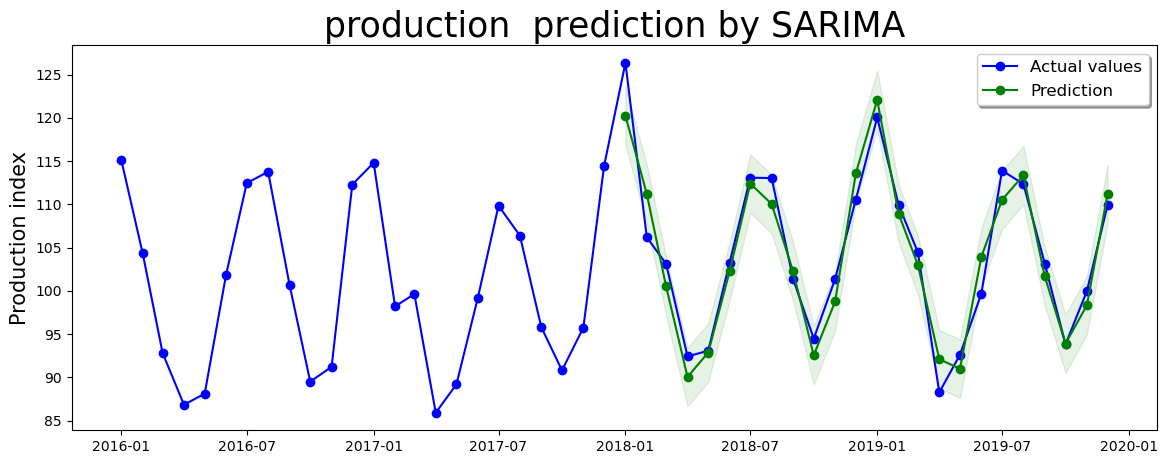

In [51]:
plt.figure(figsize=(14,5))
plt.title("production  prediction by SARIMA", fontsize=25)

plt.plot(df[-48:].index,df[-48:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Production index', fontsize=15)
plt.show()

In [52]:

mse = mean_squared_error(df[-24:]['production'], mean_prediction)
print('mse:',mse)
rmse = np.sqrt(mean_squared_error(df[-24:]['production'], mean_prediction))
print('rmse:', rmse)


mse: 6.981074405908433
rmse: 2.642172289217422


## SARIMA Forecast


In [53]:
forecast = sarima_model.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")

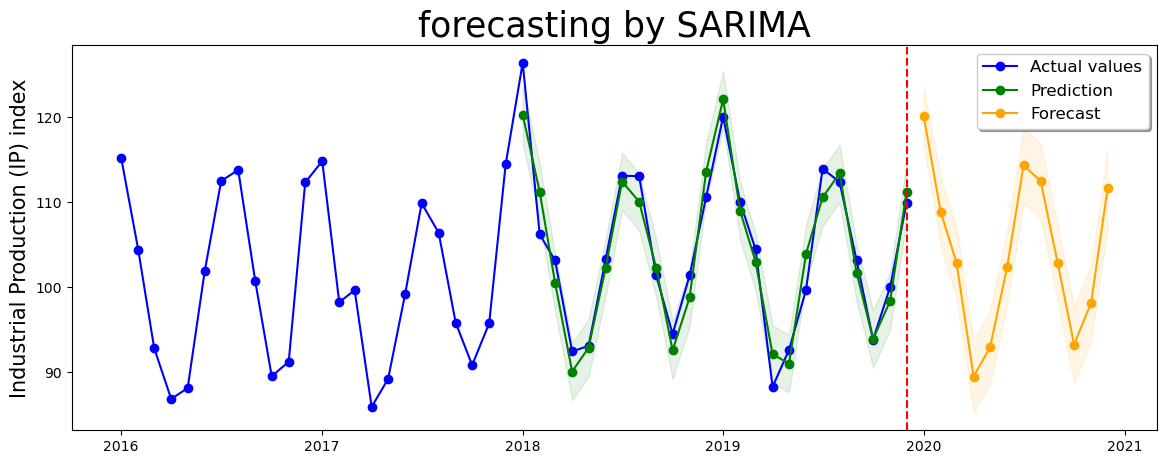

In [54]:
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

plt.figure(figsize=(14,5))
plt.title("forecasting by SARIMA", fontsize=25)

plt.plot(df[-48:].index,df[-48:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.plot(mean_forecast[-24:].index,mean_forecast[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast[-24:].index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(df.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

For better Results we can  use the triplets of parameters to automate the process of training and evaluating SARIMA models on different combinations (grid search). But with limitation of computation we will just stick with that result.

## AUTO ARIMA

The auto_arima  automatically selects the best model (ARIMA or seasonal ARIMA) by performing model selection based on AIC (Akaike Information Criterion) wich is a great alternative to traditional grid search.

In [ ]:
!pip install pmdarima


In [55]:
model_auto = pm.auto_arima(df['production'], 
                      seasonal=True,  
                      m=12, 
                      stepwise=True,  
                      trace=True)
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3985.567, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6036.213, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5193.671, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6034.614, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=3982.475, Time=4.50 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=4057.249, Time=4.87 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=3988.296, Time=4.83 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3981.119, Time=4.23 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=3897.978, Time=4.22 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=4619.332, Time=1.58 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : 

In [57]:
n_periods = 24
start_idx = len(df) - n_periods  
end_idx = len(df) - 1         

past_predictions = model_auto.predict_in_sample(start=start_idx, end=end_idx)

past_prediction_series = pd.Series(
    past_predictions, index=df.index[start_idx:end_idx + 1], name='Past Prediction'
)


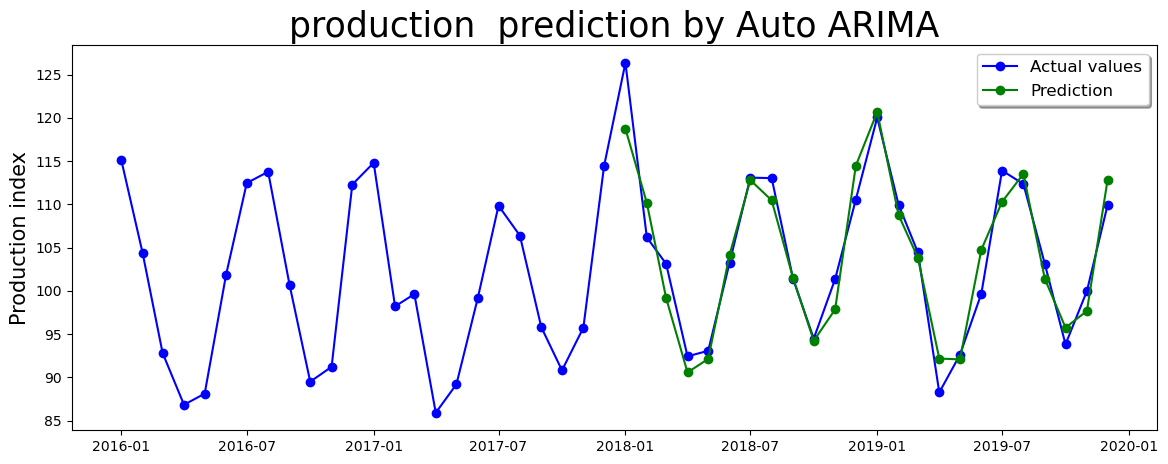

In [58]:


plt.figure(figsize=(14,5))
plt.title("production  prediction by Auto ARIMA", fontsize=25)

plt.plot(df[-48:].index,df[-48:].values, label='Actual values', color="blue", marker="o")

plt.plot(past_prediction_series[-24:].index, past_prediction_series[-24:].values,label='Prediction', color="green", marker="o")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Production index', fontsize=15)
plt.show()

In [59]:
from sklearn.metrics import mean_absolute_error, r2_score

mse = mean_squared_error(df[-24:]['production'], past_prediction_series)
print('mse:',mse)
rmse = np.sqrt(mean_squared_error(df[-24:]['production'], past_prediction_series))
print('rmse:', rmse)


mse: 8.662420983435949
rmse: 2.9431991069983607


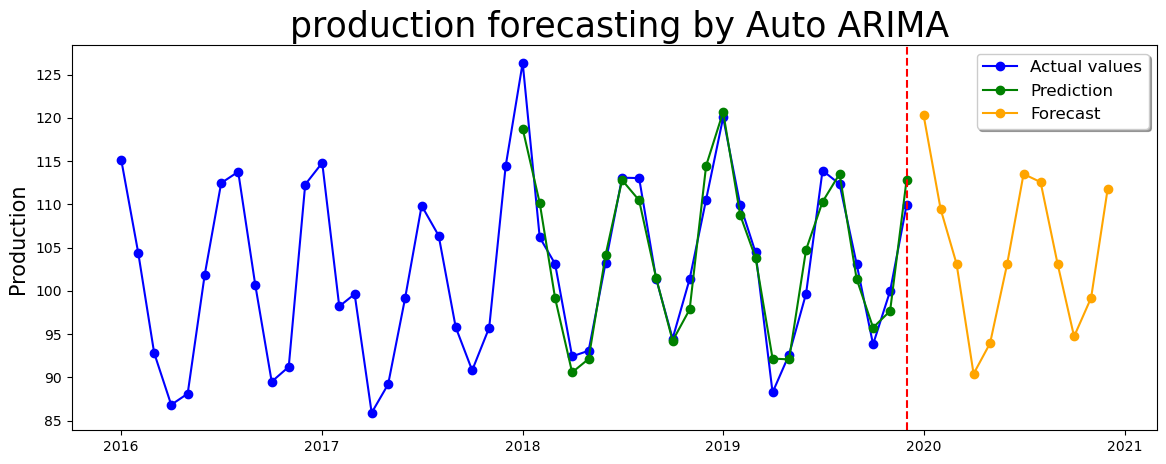

In [61]:
forecast = model_auto.predict(n_periods=12)


plt.figure(figsize=(14,5))
plt.title(" production forecasting by Auto ARIMA", fontsize=25)

plt.plot(df[-48:].index,df[-48:].values, label='Actual values', color="blue", marker="o")

plt.plot(past_predictions[-24:].index, past_predictions[-24:].values,label='Prediction', color="green", marker="o")

plt.plot(forecast[-24:].index,forecast[-24:].values, label='Forecast', color="orange", marker="o")

plt.axvline(df.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Production ', fontsize=15)
plt.show()

## PROPHET

In [ ]:
!pip install prophet

In [63]:
from prophet import Prophet

In [64]:

df_prophet = df.reset_index()[['date', 'production']].rename(columns={'date': 'ds', 'production': 'y'})

train_data = df_prophet[df_prophet['ds'] < '2018-01-01']
test_data = df_prophet[df_prophet['ds'] >= '2018-01-01']

model = Prophet(seasonality_mode='multiplicative')  
model.fit(train_data)


future = model.make_future_dataframe(periods=len(test_data), freq='MS')
forecast = model.predict(future)

actual = test_data['y'].values
predicted = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat'].values



mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

15:42:08 - cmdstanpy - INFO - Chain [1] start processing
15:42:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 7.003490531078551
Root Mean Squared Error (RMSE): 2.646410877221931


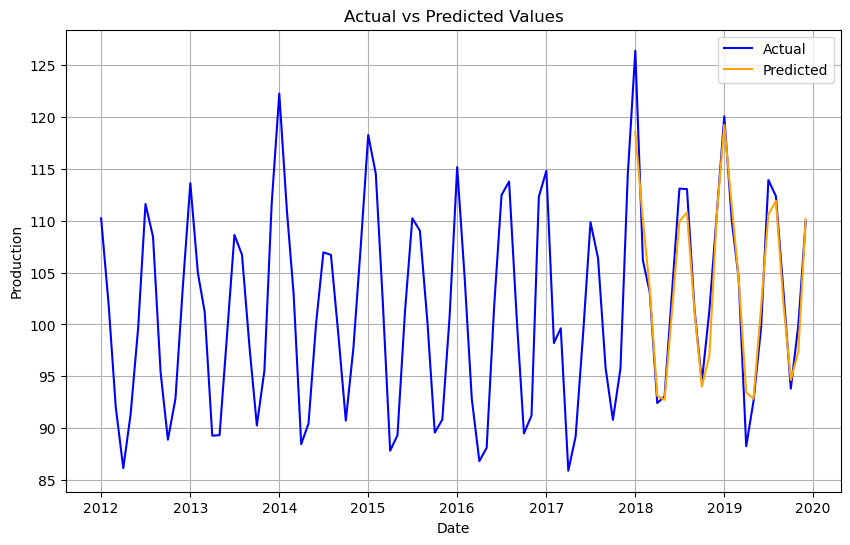

In [65]:
comparison_df = test_data[['ds', 'y']].copy()  
comparison_df['predicted'] = predicted  
t = t = df['2012':]
plt.figure(figsize=(10, 6))
plt.plot(t.index, t['production'], label='Actual', color='blue')
plt.plot(comparison_df['ds'], comparison_df['predicted'], label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

The following is an example of Out-of-Sample Predictions

In [66]:

df_prophet = df.reset_index()[['date', 'production']].rename(columns={'date': 'ds', 'production': 'y'})

model = Prophet(seasonality_mode='multiplicative')  
model.fit(df_prophet)
future = model.make_future_dataframe(periods=96, freq='MS')  # For 3 years
forecast = model.predict(future)



15:42:12 - cmdstanpy - INFO - Chain [1] start processing
15:42:12 - cmdstanpy - INFO - Chain [1] done processing


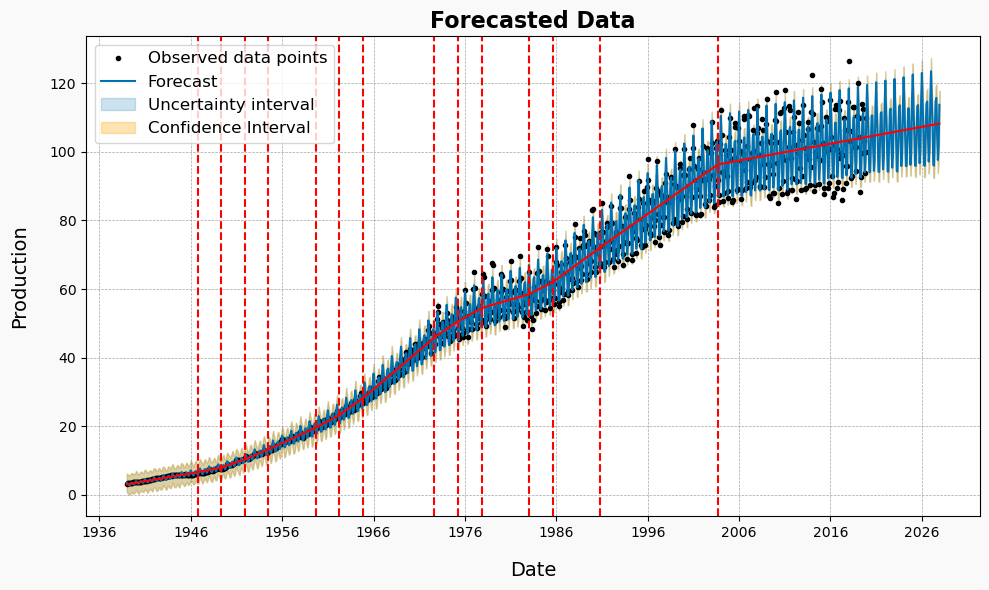

In [67]:

fig1 = model.plot(forecast)

ax = fig1.gca()  # Get current axes

# Enhance titles and labels
ax.set_title("Forecasted Data", fontsize=16, fontweight='bold')
ax.set_xlabel("Date", fontsize=14, labelpad=15)
ax.set_ylabel("Production", fontsize=14, labelpad=15)

# Adjust grid and background
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
fig1.set_facecolor('#f9f9f9')  # Light background

# Add confidence interval customization
ax.fill_between(
    forecast['ds'], 
    forecast['yhat_lower'], 
    forecast['yhat_upper'], 
    color='orange', 
    alpha=0.3, 
    label='Confidence Interval'
)

# Add changepoints (optional, if changepoints are detected)
add_changepoints_to_plot(ax, model, forecast)

# Add legend and tighten layout
ax.legend(loc='upper left', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

## LSTM Model

The first thing we must do is to properly shape the input data. When modeling a time series by LSTM RNN, it is crucial to to properly shape the input data in a sliding windows format. In this application, the data is given as monthly data. So, for example, we can use a 12 steps prediction window. This means that we use 12 samples of data (data of an entire year).

In [68]:
prediction_window=12
n_input=12 
n_features=1

In [69]:
train = df.copy()

### Scaling the Data
We use `MinMaxScaler` to scale the training data to a range between 0 and 1.  
This is important for LSTM models because they perform better when input data is normalized, ensuring faster convergence and improved performance.

In [70]:


scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

### Creating Sliding Windows
This function generates input-output pairs for the LSTM model:  
- **Purpose**: To prepare sequences (`X_train`) and their corresponding targets (`y_train`).  
- **Why we need it**: LSTMs require sequential data as input to learn patterns over time. The sliding window approach extracts overlapping sequences of length `n_input` from the dataset.


In [71]:
def sliding_windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [72]:
x, y = sliding_windows(scaled_train, prediction_window)

In [84]:
train_size = int(len(train) - 36)  
valid_size = len(train) - train_size 
test_size = len(x) - train_size - valid_size  

# Split the data
X_train = torch.Tensor(np.array(x[:train_size]))
y_train = torch.Tensor(np.array(y[:train_size]))

X_valid = torch.Tensor(np.array(x[train_size:train_size + valid_size]))
y_valid = torch.Tensor(np.array(y[train_size:train_size + valid_size]))

X_test = torch.Tensor(np.array(x[train_size + valid_size:]))
y_test = torch.Tensor(np.array(y[train_size + valid_size:]))

### Converting Data to Tensors
- **Purpose**: Convert the data into PyTorch tensors for compatibility with the LSTM model.  
- **Why we need it**: PyTorch models require input and output data in tensor format.  
- Data is split into training and validation sets, with the training set used for model learning and the validation set used for performance evaluation.


In [85]:

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

X_train = torch.Tensor(np.array(x[:train_size]))
y_train = torch.Tensor(np.array(y[:train_size]))

X_valid = torch.Tensor(np.array(x[train_size:len(x)]))
y_valid = torch.Tensor(np.array(y[train_size:len(y)]))

### Defining the LSTM Model
- **Purpose**: Create an LSTM-based neural network for time-series prediction.  
- **Why we need it**: LSTM layers are designed to capture sequential dependencies in data, making them ideal for time-series tasks.  

**Key Components**:  
1. **LSTM Layer**: Processes sequential data and learns temporal patterns.  
   - Parameters:  
     - `input_size`: Number of features in the input data.  
     - `hidden_size`: Number of units in the hidden layer.  
     - `num_layers`: Number of stacked LSTM layers.  
2. **Fully Connected Layer**: Maps the LSTM output to the target prediction.  

**Forward Pass**:  
- Initializes hidden (`h0`) and cell states (`c0`) to zeros.  
- Passes input data through the LSTM layer.  
- Uses the last hidden state to make predictions via the fully connected layer.


In [86]:

class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  

        out, (h_out, c_out) = self.lstm(x, (h0, c0))

        out = self.fc(h_out[-1])

        return out

In [87]:
EPOCHS = 2000
LEARNING_RATE = 0.008
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

In [88]:
model = LSTMNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

early_stopping_patience = 150
early_stopping_counter = 0
valid_loss_min = float('inf')




### Training the LSTM Model
- **Purpose**: Train the LSTM model using the training data and evaluate it on the validation set during each epoch.  
- **Why we need it**: The training loop updates model weights to minimize the loss, while validation monitors performance to avoid overfitting.  

**Key Steps**:  
1. **Training Phase**:  
   - `model.train()`: Puts the model in training mode.  
   - Gradients are cleared, predictions are made, and loss is computed.  
   - Backpropagation (`train_loss.backward()`) updates model weights using the optimizer.  

2. **Validation Phase**:  
   - `model.eval()`: Puts the model in evaluation mode (disables gradient calculations).  
   - Validation loss is computed without updating the weights.  

3. **Early Stopping**:  
   - Saves the model if validation loss improves.  
   - Stops training if the validation loss does not improve for `early_stopping_patience` epochs.  

4. **Output**:  
   - Training and validation loss are printed for each epoch to track progress.  


In [89]:
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    train_loss = criterion(output, y_train)

    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)

        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Epoch {epoch + 1}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
            valid_loss_min = valid_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    # Print training and validation loss for each epoch
    print(f'\t Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f} | Best Validation Loss: {valid_loss_min:.4f}\n')


Epoch 1: Validation loss decreased (inf --> 0.371018). Saving model...
	 Train Loss: 0.2059 | Validation Loss: 0.3710 | Best Validation Loss: 0.3710

Epoch 2: Validation loss decreased (0.371018 --> 0.125892). Saving model...
	 Train Loss: 0.1138 | Validation Loss: 0.1259 | Best Validation Loss: 0.1259

Epoch 3: Validation loss decreased (0.125892 --> 0.035565). Saving model...
	 Train Loss: 0.0584 | Validation Loss: 0.0356 | Best Validation Loss: 0.0356

	 Train Loss: 0.1914 | Validation Loss: 0.0878 | Best Validation Loss: 0.0356

	 Train Loss: 0.0530 | Validation Loss: 0.2107 | Best Validation Loss: 0.0356

	 Train Loss: 0.0678 | Validation Loss: 0.2771 | Best Validation Loss: 0.0356

	 Train Loss: 0.0848 | Validation Loss: 0.3072 | Best Validation Loss: 0.0356

	 Train Loss: 0.0938 | Validation Loss: 0.3153 | Best Validation Loss: 0.0356

	 Train Loss: 0.0964 | Validation Loss: 0.3091 | Best Validation Loss: 0.0356

	 Train Loss: 0.0944 | Validation Loss: 0.2926 | Best Validation L

	 Train Loss: 0.0022 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0068 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0068 | Best Validation Loss: 0.0067

	 Train Loss: 0.0022 | Validation Loss: 0.0068 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

Epoch 99: Validation loss decreased (0.006724 --> 0.006700). Saving model...
	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

Epoch 100: Validation loss decreased (0.006700 --> 0.006684). Saving model...
	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

Epoch 101: Validation loss decreased (0.006684 --> 0.006678). Saving model...
	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Validation Loss: 0.0067

	 Train Loss: 0.0021 | Validation Loss: 0.0067 | Best Va

Epoch 161: Validation loss decreased (0.006371 --> 0.006364). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0064 | Best Validation Loss: 0.0064

Epoch 162: Validation loss decreased (0.006364 --> 0.006356). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0064 | Best Validation Loss: 0.0064

Epoch 163: Validation loss decreased (0.006356 --> 0.006348). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0063 | Best Validation Loss: 0.0063

Epoch 164: Validation loss decreased (0.006348 --> 0.006341). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0063 | Best Validation Loss: 0.0063

Epoch 165: Validation loss decreased (0.006341 --> 0.006335). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0063 | Best Validation Loss: 0.0063

Epoch 166: Validation loss decreased (0.006335 --> 0.006330). Saving model...
	 Train Loss: 0.0020 | Validation Loss: 0.0063 | Best Validation Loss: 0.0063

Epoch 167: Validation loss decreased (0.006330 --> 0.00632

Epoch 216: Validation loss decreased (0.005936 --> 0.005925). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0059 | Best Validation Loss: 0.0059

Epoch 217: Validation loss decreased (0.005925 --> 0.005914). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0059 | Best Validation Loss: 0.0059

Epoch 218: Validation loss decreased (0.005914 --> 0.005903). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0059 | Best Validation Loss: 0.0059

Epoch 219: Validation loss decreased (0.005903 --> 0.005891). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0059 | Best Validation Loss: 0.0059

Epoch 220: Validation loss decreased (0.005891 --> 0.005880). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0059 | Best Validation Loss: 0.0059

Epoch 221: Validation loss decreased (0.005880 --> 0.005868). Saving model...
	 Train Loss: 0.0019 | Validation Loss: 0.0059 | Best Validation Loss: 0.0059

Epoch 222: Validation loss decreased (0.005868 --> 0.00585

Epoch 275: Validation loss decreased (0.005069 --> 0.005052). Saving model...
	 Train Loss: 0.0016 | Validation Loss: 0.0051 | Best Validation Loss: 0.0051

Epoch 276: Validation loss decreased (0.005052 --> 0.005035). Saving model...
	 Train Loss: 0.0016 | Validation Loss: 0.0050 | Best Validation Loss: 0.0050

Epoch 277: Validation loss decreased (0.005035 --> 0.005017). Saving model...
	 Train Loss: 0.0016 | Validation Loss: 0.0050 | Best Validation Loss: 0.0050

Epoch 278: Validation loss decreased (0.005017 --> 0.004999). Saving model...
	 Train Loss: 0.0016 | Validation Loss: 0.0050 | Best Validation Loss: 0.0050

Epoch 279: Validation loss decreased (0.004999 --> 0.004981). Saving model...
	 Train Loss: 0.0016 | Validation Loss: 0.0050 | Best Validation Loss: 0.0050

Epoch 280: Validation loss decreased (0.004981 --> 0.004963). Saving model...
	 Train Loss: 0.0016 | Validation Loss: 0.0050 | Best Validation Loss: 0.0050

Epoch 281: Validation loss decreased (0.004963 --> 0.00494

Epoch 332: Validation loss decreased (0.002942 --> 0.002846). Saving model...
	 Train Loss: 0.0009 | Validation Loss: 0.0028 | Best Validation Loss: 0.0028

Epoch 333: Validation loss decreased (0.002846 --> 0.002746). Saving model...
	 Train Loss: 0.0009 | Validation Loss: 0.0027 | Best Validation Loss: 0.0027

Epoch 334: Validation loss decreased (0.002746 --> 0.002642). Saving model...
	 Train Loss: 0.0008 | Validation Loss: 0.0026 | Best Validation Loss: 0.0026

Epoch 335: Validation loss decreased (0.002642 --> 0.002533). Saving model...
	 Train Loss: 0.0008 | Validation Loss: 0.0025 | Best Validation Loss: 0.0025

Epoch 336: Validation loss decreased (0.002533 --> 0.002422). Saving model...
	 Train Loss: 0.0008 | Validation Loss: 0.0024 | Best Validation Loss: 0.0024

Epoch 337: Validation loss decreased (0.002422 --> 0.002308). Saving model...
	 Train Loss: 0.0007 | Validation Loss: 0.0023 | Best Validation Loss: 0.0023

Epoch 338: Validation loss decreased (0.002308 --> 0.00219

	 Train Loss: 0.0006 | Validation Loss: 0.0018 | Best Validation Loss: 0.0015

	 Train Loss: 0.0006 | Validation Loss: 0.0019 | Best Validation Loss: 0.0015

	 Train Loss: 0.0006 | Validation Loss: 0.0020 | Best Validation Loss: 0.0015

	 Train Loss: 0.0006 | Validation Loss: 0.0020 | Best Validation Loss: 0.0015

	 Train Loss: 0.0006 | Validation Loss: 0.0019 | Best Validation Loss: 0.0015

	 Train Loss: 0.0005 | Validation Loss: 0.0018 | Best Validation Loss: 0.0015

	 Train Loss: 0.0005 | Validation Loss: 0.0018 | Best Validation Loss: 0.0015

	 Train Loss: 0.0005 | Validation Loss: 0.0019 | Best Validation Loss: 0.0015

	 Train Loss: 0.0005 | Validation Loss: 0.0019 | Best Validation Loss: 0.0015

	 Train Loss: 0.0005 | Validation Loss: 0.0019 | Best Validation Loss: 0.0015

	 Train Loss: 0.0005 | Validation Loss: 0.0018 | Best Validation Loss: 0.0015

	 Train Loss: 0.0005 | Validation Loss: 0.0017 | Best Validation Loss: 0.0015

	 Train Loss: 0.0005 | Validation Loss: 0.0017 | Bes

Epoch 526: Validation loss decreased (0.001548 --> 0.001547). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 527: Validation loss decreased (0.001547 --> 0.001546). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 528: Validation loss decreased (0.001546 --> 0.001544). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 529: Validation loss decreased (0.001544 --> 0.001542). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 530: Validation loss decreased (0.001542 --> 0.001540). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 531: Validation loss decreased (0.001540 --> 0.001539). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 532: Validation loss decreased (0.001539 --> 0.00153

Epoch 580: Validation loss decreased (0.001469 --> 0.001468). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 581: Validation loss decreased (0.001468 --> 0.001466). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 582: Validation loss decreased (0.001466 --> 0.001465). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 583: Validation loss decreased (0.001465 --> 0.001464). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 584: Validation loss decreased (0.001464 --> 0.001462). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 585: Validation loss decreased (0.001462 --> 0.001461). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0015 | Best Validation Loss: 0.0015

Epoch 586: Validation loss decreased (0.001461 --> 0.00145

Epoch 639: Validation loss decreased (0.001391 --> 0.001389). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0014 | Best Validation Loss: 0.0014

Epoch 640: Validation loss decreased (0.001389 --> 0.001388). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0014 | Best Validation Loss: 0.0014

Epoch 641: Validation loss decreased (0.001388 --> 0.001386). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0014 | Best Validation Loss: 0.0014

Epoch 642: Validation loss decreased (0.001386 --> 0.001385). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0014 | Best Validation Loss: 0.0014

Epoch 643: Validation loss decreased (0.001385 --> 0.001384). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0014 | Best Validation Loss: 0.0014

Epoch 644: Validation loss decreased (0.001384 --> 0.001382). Saving model...
	 Train Loss: 0.0004 | Validation Loss: 0.0014 | Best Validation Loss: 0.0014

Epoch 645: Validation loss decreased (0.001382 --> 0.00138

	 Train Loss: 0.0006 | Validation Loss: 0.0052 | Best Validation Loss: 0.0012

	 Train Loss: 0.0013 | Validation Loss: 0.0038 | Best Validation Loss: 0.0012

	 Train Loss: 0.0018 | Validation Loss: 0.0049 | Best Validation Loss: 0.0012

	 Train Loss: 0.0012 | Validation Loss: 0.0026 | Best Validation Loss: 0.0012

	 Train Loss: 0.0006 | Validation Loss: 0.0027 | Best Validation Loss: 0.0012

	 Train Loss: 0.0012 | Validation Loss: 0.0018 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0041 | Best Validation Loss: 0.0012

	 Train Loss: 0.0010 | Validation Loss: 0.0020 | Best Validation Loss: 0.0012

	 Train Loss: 0.0005 | Validation Loss: 0.0019 | Best Validation Loss: 0.0012

	 Train Loss: 0.0008 | Validation Loss: 0.0014 | Best Validation Loss: 0.0012

	 Train Loss: 0.0004 | Validation Loss: 0.0025 | Best Validation Loss: 0.0012

	 Train Loss: 0.0006 | Validation Loss: 0.0020 | Best Validation Loss: 0.0012

	 Train Loss: 0.0005 | Validation Loss: 0.0012 | Bes

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Best Validation Loss: 0.0012

	 Train Loss: 0.0003 | Validation Loss: 0.0013 | Bes

In [90]:
model.eval() 

with torch.no_grad():  
    predictions = model(X_valid) 
    predictions = predictions.numpy()  
    y_valid = y_valid.numpy() 

    mse = mean_squared_error(y_valid, predictions)
    
    mae = mean_absolute_error(y_valid, predictions)
    
    # Calculate R-squared (R²)
    r2 = r2_score(y_valid, predictions)

    # Print the results
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'R-Squared (R²): {r2:.4f}')

Mean Squared Error (MSE): 0.0012
Mean Absolute Error (MAE): 0.0279
R-Squared (R²): 0.7818


In [91]:
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [92]:
valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

In [93]:
df_pred=train.iloc[-24:]
df_pred['prediction']=y_pred

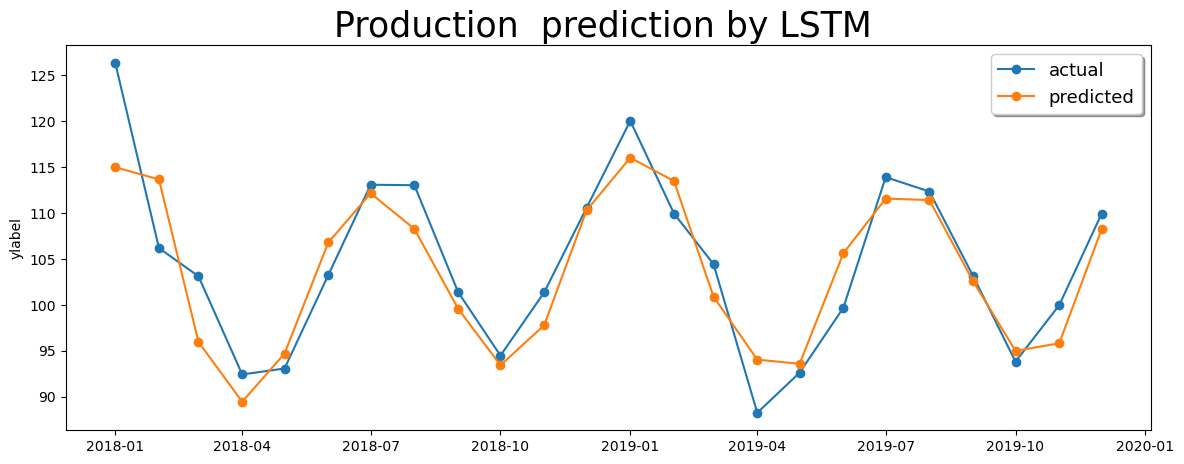

In [94]:
plt.figure(figsize=(14,5))
plt.plot(df_pred.index,df_pred["production"], label="actual", marker="o")
plt.plot(df_pred.index,df_pred["prediction"], label="predicted", marker="o")
plt.title("Production  prediction by LSTM ", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In [95]:
import torch

test_predictions = []

first_eval_batch = torch.Tensor(scaled_train[-n_input:]).reshape(1, n_input, n_features)  # (1, 12, 1)
current_batch = first_eval_batch

for _ in range(len(scaled_train[-n_input:])):  
    current_pred = model(current_batch)
    
    test_predictions.append(current_pred.item())  
    
    current_pred = current_pred.unsqueeze(0)  

    current_batch = torch.cat((current_batch[:, 1:, :], current_pred), dim=1)

print("Test Predictions:", test_predictions)


Test Predictions: [0.9171077013015747, 0.8889654278755188, 0.8021625876426697, 0.7228884696960449, 0.7371916770935059, 0.829501748085022, 0.8968872427940369, 0.8777133822441101, 0.802967369556427, 0.7418825030326843, 0.7613503336906433, 0.8451187014579773]


In [96]:
forec_vals = np.array(test_predictions).reshape(-1, 1)  
forec_vals = scaler.inverse_transform(forec_vals) 


In [97]:
date_offset=12
forecast_dates =  (train.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [98]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['prediction'] = forec_vals

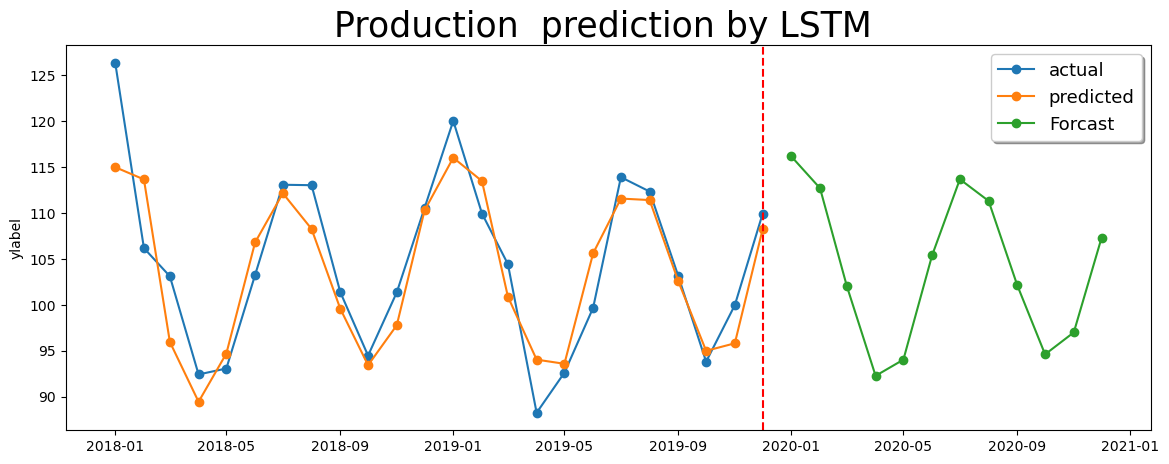

In [99]:
plt.figure(figsize=(14,5))
plt.plot(df_pred.index,df_pred["production"], label="actual", marker="o")
plt.plot(df_pred.index,df_pred["prediction"], label="predicted", marker="o")
plt.plot(df_forecast.index,df_forecast["prediction"], label="Forcast", marker="o")
plt.axvline(df_pred.index[-1], color="red", linestyle="--")

plt.title("Production  prediction by LSTM ", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()